# Part III: Model Training for Left Right Fingerprints

Now that we understand our data and have it normalized, we can begin experimenting with a model that will predict if a fingerprint originated from a left or right hand. Is this simple, yes. This will allow us to get into production faster and improve the baseline.

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
! pip install -r ../requirements.txt -q

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from IPython.display import clear_output

2023-11-21 19:44:57.667068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 19:44:57.667117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 19:44:57.667149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 19:44:57.676127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 19:44:58.795463: W tensorflow/compiler/

## Check TF and Cuda versions

For reference [see this chart](https://www.tensorflow.org/install/source#gpu)

Expected output
```
TensorFlow: 2.14.0
TensorFlow Datasets: 4.9.3
OpenCV version: 4.8.1
Cuda version: 11.8
cudnn version: 8
```

In [3]:
# check versions for Tensorflow and Cuda
print('TensorFlow: ' + tf.__version__)
print('TensorFlow Datasets: ' + tfds.__version__)
print('OpenCV version: ' + cv2.__version__)

# Check CUDA Version
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda version: ' + cuda_version)

# Check CUDNN Version
cudnn_version = sys_details["cudnn_version"]  
print('cudnn version: ' + cudnn_version)

TensorFlow: 2.14.0
TensorFlow Datasets: 4.9.3
OpenCV version: 4.8.1
Cuda version: 11.8
cudnn version: 8


In [4]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# Create the training and validation dataset

This function streamlines the creation of TensorFlow datasets for training and validation, encapsulating several steps such as loading, preprocessing, caching, and prefetching, making it easier to manage datasets for machine learning models.

### Function's Main Operations:

- image_dataset_from_directory: Utilizes TensorFlow's image_dataset_from_directory function to create a dataset from the specified directory with provided configurations.
Data Transformations:
- cache: Caches the dataset in memory after the initial data loading for faster access during training.
- shuffle: Shuffles the dataset with a buffer size of 1000.
- prefetch: Prefetches data, preparing subsequent batches while the model is executing computations on the current batch, optimizing data pipeline performance.

### Return:

Returns the processed dataset ready for training or validation.

In [5]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def create_image_dataset(directory, color_mode="grayscale", validation_split=0.2,
                         subset=None, seed=123, image_size=(96, 96), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        color_mode=color_mode,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )
    
    dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [6]:
train_ds = create_image_dataset(
    scratch_path + '/processed/hand',
    subset="training",
)

Found 17953 files belonging to 2 classes.
Using 14363 files for training.


2023-11-21 19:45:02.120274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 19:45:02.120688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 19:45:02.121037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
val_ds = create_image_dataset(
    scratch_path + '/processed/hand',
    subset="validation",
)

Found 17953 files belonging to 2 classes.
Using 3590 files for validation.


Here are the first nine images from the training dataset with their corresponding labels.

In [8]:
# Get class names by iterating through train_ds and adding 'left' and 'right'
class_names = train_ds.class_names if hasattr(train_ds, 'class_names') else [str(label) for label in sorted(set(train_ds.map(lambda x, y: y).unbatch().as_numpy_iterator()))]
class_names += ['left', 'right']
class_names = sorted(set(class_names))  # Ensure uniqueness and sort

print(class_names)

['0', '1', 'left', 'right']


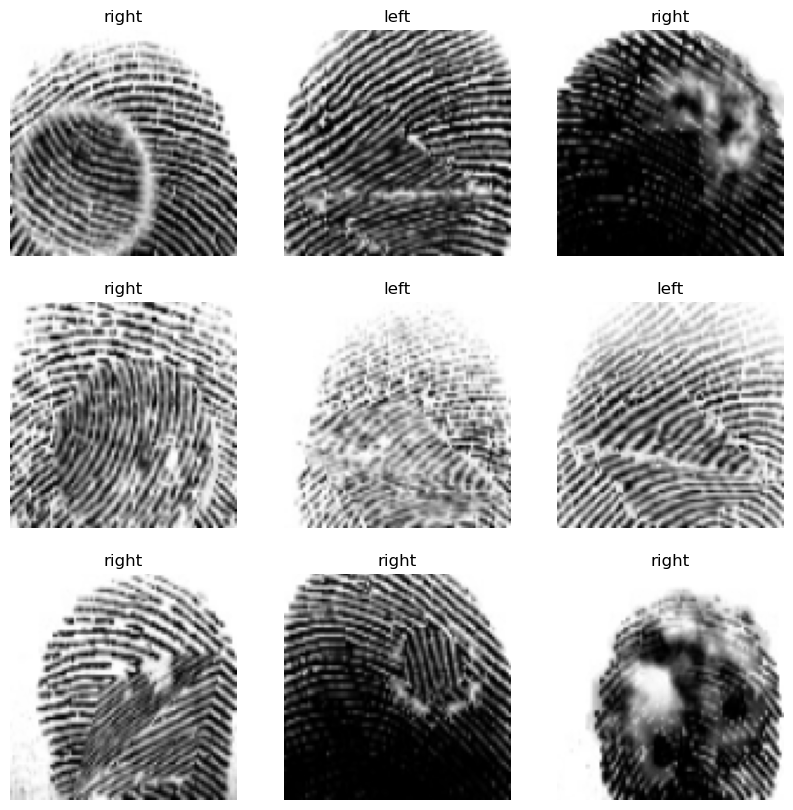

In [9]:
import matplotlib.pyplot as plt

label_mapping = {0: 'left', 1: 'right'}  # Define the mapping

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        # Replace label with corresponding class name using the mapping
        plt.title(label_mapping.get(labels[i].numpy(), 'Unknown'))
        plt.axis("off")
plt.show()

Pass the datasets to the Keras Model.fit method for training in later steps.

Use the image_batch tensor of  shape (32, 96, 96, 1), which splits batch of 32 images of shape 96x96x3 (the last dimension refers to color channels grayscale). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 1)
(32,)


## Distrubited Training Strategy

`tf.distribute.Strategy` is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes. [Types of strategies](https://www.tensorflow.org/guide/distributed_training).

In [11]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [12]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


## GPU Memory Allocation

The `TF_GPU_ALLOCATORvariable` enables the memory allocator using cudaMallocAsync available since CUDA 11.2. It has fewer fragmentation issues than the default BFC memory allocator. Note, this could become the default in the future.

This environment variable is unset by default. To enable the variable, run the following command:

In [13]:
# cuda_malloc_async has fewer fragmentation issues than the default BFC memory allocator - https://docs.nvidia.com/deeplearning/frameworks/tensorflow-user-guide/index.html#tf_gpu_allocator
TF_FORCE_GPU_ALLOW_GROWTH=True

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
print(os.getenv("TF_GPU_ALLOCATOR"))

cuda_malloc_async


## Create Model Function

This function encapsulates the creation and compilation of a CNN model for image classification tasks. It provides flexibility to specify the class names and input image shape, enabling the user to adapt the model for different classification problems and data formats.

### Function's Main Operations:
- Model Creation:
    - Utilizes a distributed strategy (tf.distribute.MirroredStrategy()) for training across multiple devices (if available).
    - Constructs a sequential model using Keras (Sequential).
    - The model architecture consists of several layers:
        - Convolutional layers (Conv2D) with varying filter sizes and activation functions (ReLU), followed by max-pooling layers (MaxPooling2D).
        - Flattening layer (Flatten) to transform the output of the convolutional layers into a 1D tensor.
        - Dense layers (Dense) for classification, with ReLU activation for hidden layers and linear activation for the output layer.

### Compilation:
- Compiles the model using the Adam optimizer ('adam'), sparse categorical cross-entropy loss function (tf.keras.losses.SparseCategoricalCrossentropy), and accuracy as the metric for evaluation.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

def create_model(class_names=None, input_image_shape=(96, 96, 1)):
    if class_names is None:
        class_names = ['left', 'right',]  # Define default class names here

    strategy = tf.distribute.MirroredStrategy()
    num_classes = len(class_names)

    with strategy.scope():
        model = Sequential([
          layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_image_shape, name="model"),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dense(num_classes)
        ])

        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    
    return model

In [15]:
# build and compile the mode
model = create_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Conv2D)              (None, 96, 96, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0

## Training Function

This function streamlines the process of training a neural network model by encapsulating the training routine with a specific model, datasets, and epochs, allowing for easier experimentation and training within the notebook or Python environment.

In [17]:
def train_model(model, train_data=train_ds, val_data=val_ds, epochs=10):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs
    )
    return history

In [18]:
# Assuming you already have your 'model', 'train_ds', and 'val_ds' variables defined
trained_history = train_model(model, train_ds, val_ds, epochs=10)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/r

2023-11-21 19:45:16.051321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-21 19:45:16.069876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-21 19:45:16.090037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-21 19:45:16.109959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-21 19:45:18.100446: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2d821f4a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-21 19:45:18.100493: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-11-21 19:45:18.100502: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-11-21 19:45:18.100510: I t

446/449 [============================>.] - ETA: 0s - loss: 2.7350 - accuracy: 0.7377INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
449/449 [==============================] - 13s 13ms/step - loss: 2.7190 - accuracy: 0.7382 - val_loss: 0.5060 - val_accuracy: 0.7604
Epoch 2/10
449/449 [==============================] - 5s 10ms/step - loss: 0.4007 - accuracy: 0.8144 - val_loss: 0.3645 - val_accuracy: 0.8348
Epoch 3/10
449/449 [==============================] - 5s 10ms/step - loss: 0.3638 - accuracy: 0.8330 - val_loss: 0.3706 - val_accuracy: 0.8407
Epoch 4/10
449/449 [==============================] - 5s 10ms/step - loss: 0.3216 - accuracy: 0.8560 - val_loss: 0.3411 - val_accuracy: 0.8501
Epoch 5/10
449/449 [==============================] - 5s 10ms/step - loss:

The performance metrics  give insight into how well your model has learned from the training data and how well it generalizes to unseen validation data.

- Loss: This represents the error or discrepancy between the predicted and actual values. Lower values indicate better performance, as it implies that the model's predictions are closer to the actual values.
- Accuracy: This metric indicates the proportion of correctly classified samples out of the total samples. An accuracy of 0.9443 for training data means that the model correctly predicted the classes for approximately 94.43% of the training set.
- Val_loss (Validation Loss): This measures the error between the predicted values and the actual values on the validation dataset. Similar to training loss, lower values are better, indicating that the model generalizes well to unseen data.
- Val_accuracy (Validation Accuracy): This represents the proportion of correctly classified samples out of the total samples in the validation dataset. An accuracy of 0.8967 for validation data suggests that the model correctly predicted the classes for approximately 89.67% of the validation set.

Overall, a high training accuracy and a relatively close validation accuracy indicate that the model is performing well, but you may want to watch out for overfitting and fine-tune the model further if necessary. Regularization techniques, adjusting model complexity, or increasing data diversity might help improve generalization to unseen data.

## Performance Visualization Function

This function, plot_training_history, takes in the history object returned by the model's fit method and the epochs parameter. It then plots the training and validation accuracy as well as the training and validation loss in two subplots, providing insights into the model's performance during training.

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

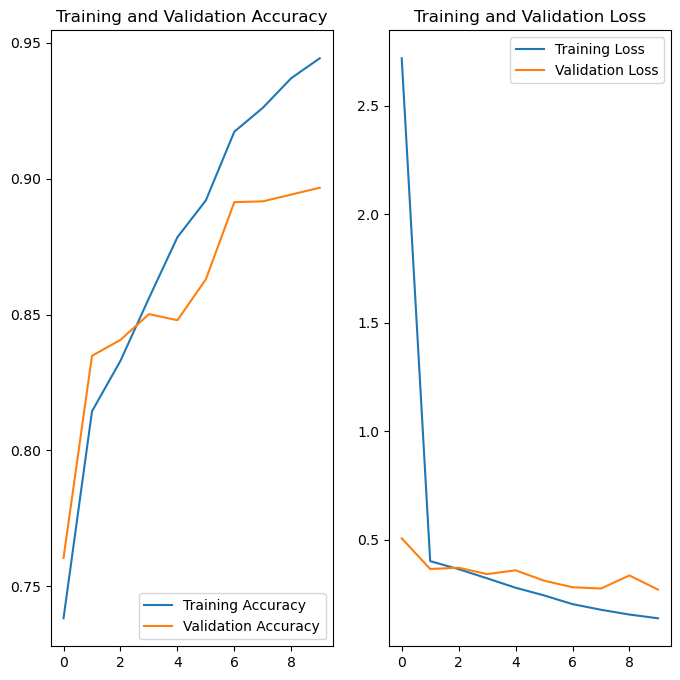

In [20]:
# Execute the performance visualization
plot_training_history(history=trained_history, epochs=10)

# Serialize Model

In [23]:
model_version = os.environ.get('VERSION', "1")

model_path = scratch_path + "/models/hand/" + model_version + "/model.savedmodel"
model.save(model_path)

INFO:tensorflow:Assets written to: ../scratch/models/hand/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: ../scratch/models/hand/1/model.savedmodel/assets


# Test with a sample

## Load the trained model

In [27]:
model_path = scratch_path + "/models/hand/" + model_version + "/model.savedmodel"
model = keras.models.load_model(model_path)

## Load a random sample input image

Files in path: 6000
Selected: 506__M_Left_little_finger.png
shape: (1, 96, 96, 1)


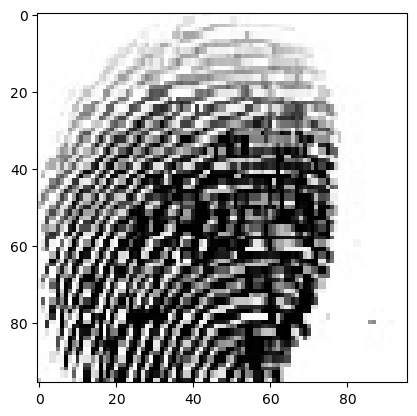

In [28]:
# select random images
import random
import matplotlib.pyplot as plt

samples_path = scratch_path + "/processed/real/"
file_list = os.listdir(samples_path)
print('Files in path: ' + str(len(file_list)))

test_image = random.choice(file_list)
print('Selected: ' + test_image)

# loads an image into PIL format.
img = tf.keras.utils.load_img(
    samples_path + test_image,
    color_mode="grayscale",
    target_size=(96, 96),
    #interpolation='nearest',
)

plt.imshow(img, cmap='gray')

# converts a PIL image instance to a numpy array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print("shape:",img_array.shape)

## Generate a prediction

In [29]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_mapping = {0: 'left', 1: 'right'}  # Define your class mapping

predicted_label = class_mapping[np.argmax(score)]
confidence = 100 * np.max(score)

print(
    f"This image {test_image} is predicted as {predicted_label} with a {confidence:.2f}% confidence."
)

# Check if the predicted label is in the test image name (case insensitive)
is_label_in_image_name = predicted_label.lower() in test_image.lower()
print(f"Is predicted label in the image name? {is_label_in_image_name}")

1/1 [==============================] - 0s 150ms/step
This image 506__M_Left_little_finger.png is predicted as left with a 100.00% confidence.
Is predicted label in the image name? True


# Upload to S3

## List the available buckets

In [30]:
# list objects using the aws s3 cli
! aws s3 ls

2023-11-21 19:33:30 managed-velero-backups-736247ed-2c46-4068-825b-be42f54d5ac3
2023-11-16 22:36:17 rosa-n6wkj-cjkpb-image-registry-us-east-2-wbgvottmvhgatruvbiyd
2023-11-18 14:58:53 sagemaker-fingerprint-data-n6wkj


## List the dynamically created bucket for the demo

In [33]:
import boto3

s3_client = boto3.client('s3')
response = s3_client.list_buckets()

filtered_buckets=[]

for bucket in response['Buckets']:
    bucket_name = bucket['Name']
    if bucket_name.startswith('sagemaker-fingerprint-'):
        filtered_buckets.append(bucket_name)
    
print(filtered_buckets)

['sagemaker-fingerprint-data-n6wkj']


## Upload the model to the demo bucket

In [36]:
import subprocess

for bucket in filtered_buckets:
    command = f"aws s3 sync ../scratch/models/hand s3://{bucket}/models/hand"
    subprocess.run(command, shell=True)

upload: ../scratch/models/hand/1/model.savedmodel/fingerprint.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/fingerprint.pb
upload: ../scratch/models/hand/1/model.savedmodel/variables/variables.index to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/variables/variables.index
upload: ../scratch/models/hand/1/model.savedmodel/keras_metadata.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/keras_metadata.pb
upload: ../scratch/models/hand/1/model.savedmodel/saved_model.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/saved_model.pb
upload: ../scratch/models/hand/1/model.savedmodel/variables/variables.data-00000-of-00001 to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/variables/variables.data-00000-of-00001


# Next Steps

Congrats! We have our first baseline model that predicts which hand an unknown fingerprint originated stored in AWS S3. Next:

Verify the model in AWS S3:
1. Go to your AWS Console
1. Go to S3 and navigate to the sagemaker-fingerprint-data- bucket
1. Go to the models subdirectory and step into the directories if you want

Check inference:
1. Go to your OpenShift Console
1. Navigate to the *Project* `models`
1. Under *Networking* go to *Routes*
1. Click the `gradio-client` URL
1. Interact with the model
